#### import

In [0]:
from google.colab import drive
drive.mount('/content/drive')
SEED = 42

In [0]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

In [0]:
path = 'drive/My Drive/bigcontest2019/scripts/model/metrics/nes_inference/merge/'


# test1_predict = pd.read_csv(path + "/../test1_predict.csv")

train_merge = pd.read_csv(path + "train_merge.csv")
test1_merge = pd.read_csv(path + "test1_merge.csv")
test2_merge = pd.read_csv(path + "test2_merge.csv")

In [0]:
test1_predict.shape

(20000, 3)

In [0]:
train_merge.shape

(40000, 70)

divide variables

#### EDA

In [0]:
test1_predict.describe()

,acc_id,survival_time,amount_spent
count,20000.000000,20000.000000,20000.000000
mean,64697.176800,40.380992,0.157074
std,37934.624602,14.996422,0.291556
min,7.000000,1.000000,0.000000
25%,31275.500000,31.371732,0.017478
50%,64604.000000,41.915424,0.099671
75%,97956.250000,52.007550,0.192299
max,130474.000000,70.276871,8.990078


In [0]:
train_merge.shape

(40000, 81)

In [0]:
all_merge.shape

(80000, 48)

In [0]:
def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(6,8,figsize=(10,10))

    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        plt.scatter(df1[feature], df2[feature], marker='+')
        plt.xlabel(feature, fontsize=9)
    plt.show();

In [0]:
# features = ['playtime', 'day', 'npc_kill', 'solo_exp', 'party_exp'
#            ]
# plot_feature_scatter(train_merge[:20000],test1_merge[:20000], features)

In [0]:
27*3

81

#### dist_plot

In [0]:
def plot_new_feature_distribution_3(df1, df2, df3, label1, label2, label3, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(24,3,figsize=(20,100))

    for feature in features:
        i += 1
        plt.subplot(24,3,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        sns.kdeplot(df3[feature], bw=0.5,label=label3)
        plt.xlabel(feature, fontsize=11)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();
    
    
def plot_new_feature_distribution_2(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(24,3,figsize=(20,100))

    for feature in features:
        i += 1
        plt.subplot(24,3,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=11)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

In [0]:
columns = ['acc_id', 'day', 'char_id', 'server', 'npc_kill', 'solo_exp',
       'party_exp', 'quest_exp', 'rich_monster', 'death', 'exp_recovery',
       'private_shop', 'game_money_change', 'game_money_change_minus',
       'enchant_count', 'level', 'pledge_cnt', 'liege', 'pledge_id',
       'pledge_combat_cnt', 'combat_play_time', 'non_combat_play_time',
       'max_spent', 'mean_spent', 'trade_day_x', 'trade_server_x',
       'item_amount_x', 't23-02_x', 't03-06_x', 't07-10_x', 't11-14_x',
       't15-18_x', 't19-22_x', 'item_price_x', 'trade_shop_x',
       'personal_shop_x', 'accessory_x', 'adena_x', 'armor_x',
       'enchant_scroll_x', 'etc_x', 'spell_x', 'weapon_x', 'source',
       'trade_day_y', 'trade_server_y', 'item_amount_y', 't23-02_y',
       't03-06_y', 't07-10_y', 't11-14_y', 't15-18_y', 't19-22_y',
       'item_price_y', 'trade_shop_y', 'personal_shop_y', 'accessory_y',
       'adena_y', 'armor_y', 'enchant_scroll_y', 'etc_y', 'spell_y',
       'weapon_y', 'target', 'attack', 'cnt', 'pledge_ratio', 'day_spent','survival_time', 'amount_spent']

In [0]:
test1_merge.describe()

,acc_id,day,char_id,server,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,exp_recovery,private_shop,game_money_change,game_money_change_minus,enchant_count,level,pledge_cnt,liege,pledge_id,pledge_combat_cnt,combat_play_time,non_combat_play_time,max_spent,mean_spent,trade_day_x,trade_server_x,item_amount_x,t23-02_x,t03-06_x,t07-10_x,t11-14_x,t15-18_x,t19-22_x,item_price_x,trade_shop_x,personal_shop_x,accessory_x,adena_x,armor_x,enchant_scroll_x,etc_x,spell_x,weapon_x,source,trade_day_y,trade_server_y,item_amount_y,t23-02_y,t03-06_y,t07-10_y,t11-14_y,t15-18_y,t19-22_y,item_price_y,trade_shop_y,personal_shop_y,accessory_y,adena_y,armor_y,enchant_scroll_y,etc_y,spell_y,weapon_y,target,attack,cnt,pledge_ratio,day_spent
count,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,16306.000000,16306.000000,16306.000000,16306.000000,9454.000000,9454.000000,12104.000000,12104.000000,1.210400e+04,12104.000000,12104.000000,12104.000000,12104.000000,12104.000000,12104.000000,12104.000000,12104.000000,12104.000000,12104.000000,12104.000000,12104.000000,12104.000000,12104.000000,12104.000000,12104.000000,12104.000000,13606.000000,13606.000000,1.360600e+04,13606.000000,13606.000000,13606.000000,13606.000000,13606.000000,13606.000000,13606.000000,13606.000000,13606.000000,13606.000000,13606.000000,13606.000000,13606.000000,13606.000000,13606.000000,13606.000000,13606.000000,16306.000000,16306.000000,16306.000000,9454.000000
mean,64697.176800,21.134650,3.76515,1.816900,15.032613,1.756386,1.450637,2.339802,2.848800,2.869940,2.084499,8.111038,2.812867,-2.753909,0.436444,14.187800,4.101258,2.662850,2.014902,4.867150,23.103092,2.725065,1.331783,0.813354,7.703652,1.296018,8.202463e+00,8.394085,1.938202,2.879792,4.928040,8.375661,10.092779,5.450054,23.464309,13.144250,3.201338,7.760740,4.672588,3.196051,14.574273,1.186137,2.017432,36.608559,7.616272,1.276496,7.401918e+00,7.532927,1.900265,3.103998,5.025577,8.042334,9.660223,3.993723,22.402249,12.863075,3.014185,7.015728,4.147655,3.761429,14.512200,1.031163,1.782963,35.265324,-4.316696,29.745988,0.312583,17.616599
std,37934.624602,9.047509,5.79773,2.161969,24.381033,4.865873,6.078425,7.588314,5.561249,7.716384,8.435229,23.440041,14.937499,14.937433,10.690566,4.250851,23.487116,12.236661,2.249991,21.458487,31.718290,7.539058,1.485050,1.018043,7.807134,1.602134,4.745672e+01,29.758634,8.125308,12.064706,14.483998,25.720244,26.189871,20.912269,69.099235,55.434975,18.381604,23.904266,16.366146,29.633527,49.382188,7.531221,8.021780,95.185887,7.118132,1.454032,4.215278e+01,30.813234,9.649886,30.708632,16.630045,26.117718,34.528815,19.535261,99.469896,38.516715,17.284166,37.522089,13.616748,13.363137,49.660736,8.828493,7.337088,111.621971,45.604161,52.231552,0.235280,24.326930
min,7.000000,1.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-673.302708,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.011735,0.011735,1.000000,1.000000,2.396984e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.396984e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-571.509853,0.000000,0.000000,0.011735
25%,31275.500000,16.000000,1.00000,1.000000,0.139569,0.010776,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036772,-0.950183,0.000000,15.000000,0.000000,0.000000,1.000000,0.000000,2.179303,0.000000,0.348521,0.275961,2.000000,1.000000,9.588080e-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,1.000000,1.610174e-

<Figure size 432x288 with 0 Axes>

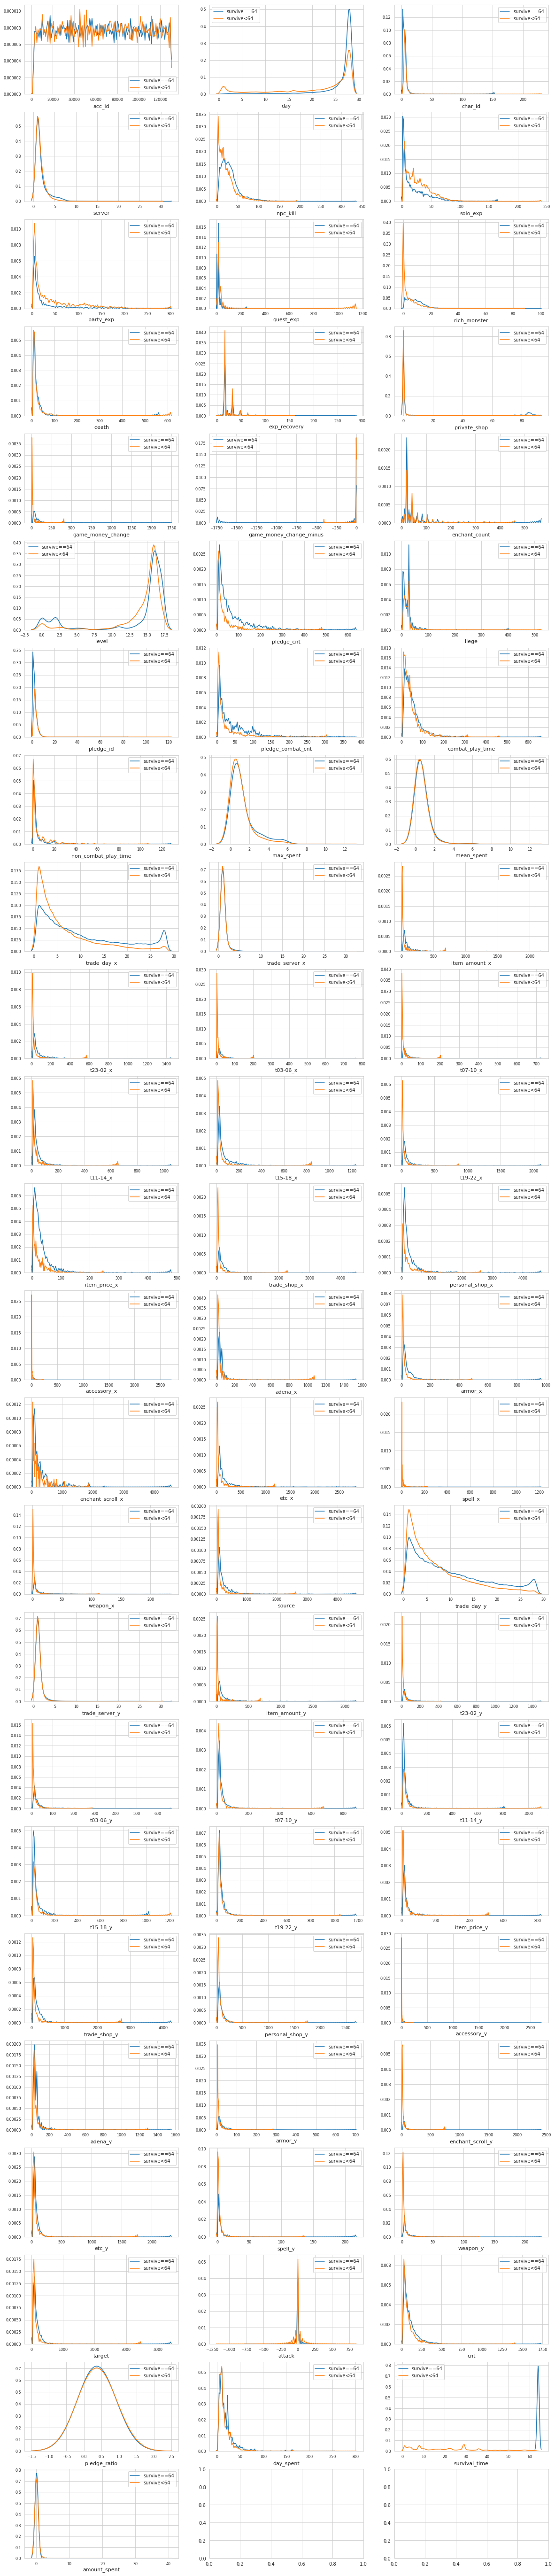

In [0]:
features = columns

t0 = train_merge.loc[train_merge['survival_time'] == 64]
t1 = train_merge.loc[train_merge['survival_time'] < 64]
plot_new_feature_distribution_2(t0, t1, 'survive==64', 'survive<64', features)

# t0 = train_merge.drop(['survival_time', 'amount_spent'], axis = 1).loc[train_merge['mean_spent'] > 5]
# t1 = test1_merge.loc[test1_merge['mean_spent'] > 5]
# t2 = test2_merge.loc[test2_merge['mean_spent'] > 5]
# plot_new_feature_distribution(t0, t1, t2,'train_merge', 'test1_merge', 'test2_merge', features)

# t0 = train_merge.loc[train_merge['survival_time'] == 64]
# t1 = train_merge.loc[(train_merge['survival_time'] > 64) & (train_merge['survival_time'] < 8)]
# t2 = train_merge.loc[train_merge['survival_time'] <= 7]
# plot_new_feature_distribution_3(t0, t1, t2, '64', '8~63', 'less 7', features)

# t0 = train_merge.drop(['survival_time', 'amount_spent'], axis = 1)
# t1 = test1_merge
# plot_new_feature_distribution(t0, t1, 'train_merge', 'test1_merge', features)

# t0 = train_merge.loc[train_merge['enchant_count'] > 200]
# t1 = train_merge.loc[train_merge['enchant_count'] <= 10]
# plot_new_feature_distribution(t0, t1, 'heavy_spent', 'light_spent', features)

# t0 = train_merge.loc[train_merge['login_day_max'] >= 20]
# t1 = train_merge.loc[train_merge['login_day_max'] <= 3]
# plot_new_feature_distribution(t0, t1, 'long_login','short_login', features) #survival_time 예측할 때만 써야 할듯. amount_spent에는 전혀 해당 없음


# # t0 = train_merge.loc[train_merge['logout_day'] <= 5]
# # t1 = train_merge.loc[train_merge['logout_day'] >= 10]
# # features = train_merge.columns
# # plot_new_feature_distribution(t0, t1, 'short_logout','long_leave', features)

# t0 = train_merge.loc[train_merge['train_day_x'] >= 20]
# t1 = train_merge.loc[train_merge['train_day_x'] == 0]
# plot_new_feature_distribution(t0, t1, 'long_shop','short_shop', features) #survival_time 예측할 때만 써야 할듯. amount_spent에는 전혀 해당 없음



# # shop을 여는 친구들은 다른 데이터가 거의 없다.


<Figure size 432x288 with 0 Axes>

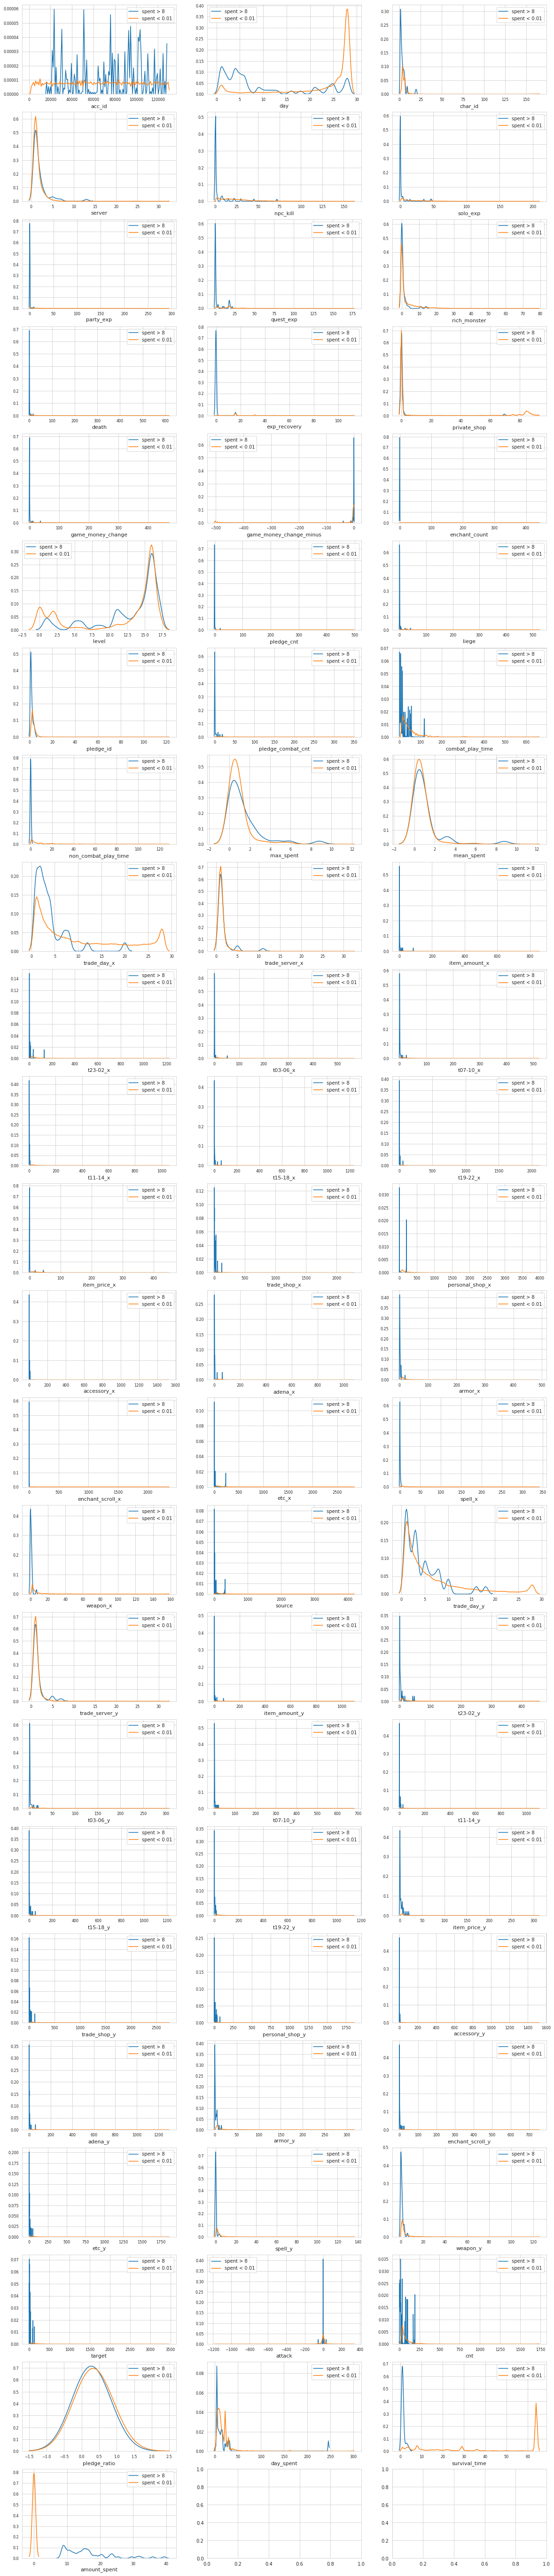

In [0]:
features = train_merge.columns

t0 = train_merge.loc[train_merge['amount_spent'] > 8]
t1 = train_merge.loc[train_merge['amount_spent'] < 0.01]
plot_new_feature_distribution_2(t0, t1, 'spent > 8', 'spent < 0.01', features)

In [0]:
train_merge.columns[0:10]

Index(['acc_id', 'survival_time', 'amount_spent', 'day', 'char_id', 'server',
       'playtime', 'npc_kill', 'solo_exp', 'party_exp'],
      dtype='object')

In [0]:
mean = train_merge['amount_spent'].mean()